In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [36]:
#### ATENTION
# Although I am defining the Greenshield here, it cannot be modified, as the transformations were make considering only the Greenshield


class Greenshield():
    def __init__(self, params):
        self.v_max = params[0]
        self.p_max = params[1]
    
    def __call__(self,density):
        return self.flux(density)
    
    def flux(self, density):
        return self.v_max * (1 - (density/self.p_max))
    
    def d_flux(self, density):
        return - self.v_max/self.p_max + 0*density
    
    def __str__(self):
        return "Greenshield"

In [37]:
sigma1 = 0.5*0.5

L = 5
l = 0.5
T = 10

a = 0.8
b = 0.75


v_max = 1.2
p_max = 1 # rho_max cannot be learned Susana's paper

In [38]:
func = Greenshield([v_max, p_max])

In [243]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.softplus(layer(x))
        x = self.layers[-1](x)
        return x

In [12]:
# Initialize the model with multiple hidden layers and 1 output layer
model_key = jax.random.PRNGKey(1)

layers_size = 100
n_layers = 1
input_dim = 2
output_dim = 1

In [13]:
# Initialize the model with multiple hidden layers and 1 output layer
model_key = jax.random.PRNGKey(1)

layers_size = 100
n_layers = 1
input_dim = 2
output_dim = 1

# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=layers_size, n_layers=n_layers, output_dim=output_dim)

In [14]:
def generate_latin_hypercube_samples(num_samples, x, t):
    # Define the ranges
    parameter_ranges = jnp.array([x, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [22]:
def pde_loss(model, x, sigma1):
    
    du_dt = jax.vmap(jax.grad(model))(x)[:, 1] # du/dt
    d2u_dx2 = jax.vmap(jax.hessian(model))(x)[:, 0, 0] # d^2 u/ dx^2

    return jnp.mean((du_dt - sigma1 * d2u_dx2)**2) # Mean Squared Error

In [41]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0],
    [2.0, 8.0]
])

In [159]:
def j(model, func, input, sigma1, v_max):
    theta, grad = jax.vmap(jax.value_and_grad(model))(input)
    hess = jax.vmap(jax.hessian(model))(input)

    d_dx = grad[:,0]
    d2_dx2 = jax.vmap(jax.hessian(model))(input)[:, 0, 0]

    c = (1+((2*sigma1*(1/theta)*d_dx)/v_max))

    i_0 = (sigma1**2/v_max)*((1/theta**2) * d_dx**2 - (1/theta)*d2_dx2 ) + 0.5*c*func(0.5*c)

    return i_0, theta, c

In [192]:
def in_loss(model, func, T, sigma1, a, steps=20):

    t = jnp.linspace(0, T, steps)
    x1_flat = jnp.zeros_like(t)
    result = jnp.stack((x1_flat, t), axis=-1)
    in_ , theta, c = j(model, func, result, sigma1, func.v_max)
    in_theorical = -a * (func.p_max - c)

    return jnp.mean((-in_ - in_theorical)**2)


In [193]:
def out_loss(model, func, T, sigma1, b, steps=20):

    t = jnp.linspace(0, T, steps)
    x1_flat = jnp.full_like(t, L)
    result = jnp.stack((x1_flat, t), axis=-1)
    out_ , theta, c = j(model, func, result, sigma1, func.v_max)
    out_theorical = b * c




    return jnp.mean((out_ - out_theorical)**2)

In [194]:
out_loss(model, func, T, sigma1, a)

Array(0.2624279, dtype=float32)

In [195]:
def time_loss(model, L, sigma1, v_max, steps=20):

    x1 = jnp.linspace(0, L, steps)
    t_flat = jnp.zeros_like(x1)
    result = jnp.stack((x1, t_flat), axis=-1)
    theta, grad = jax.vmap(jax.value_and_grad(model))(result)

    d_dx = grad[:,0]

    total = d_dx + (v_max/(2*sigma1)) * theta

    return jnp.mean(total**2)

In [196]:
time_loss(model, L, sigma1, v_max)

Array(0.10372303, dtype=float32)

In [284]:
def loss(model, func, input, L, T, sigma1, a, b, v_max, steps=20):

    return (pde_loss(model, input, sigma1) + in_loss(model, func, T, sigma1, a, steps) + 
            out_loss(model, func, T, sigma1, b, steps) + 
            0.01*time_loss(model, L, v_max, steps))

In [198]:
# def loss(model, func, input, L, T, sigma1, a, b, v_max, steps=20):

#     return (pde_loss(model, input, sigma1) + in_loss(model, func, T, sigma1, a, steps))

In [285]:
loss(model, func, batch_input_data, L, T, sigma1, a, b, v_max, steps=20)

Array(0.21634719, dtype=float32)

In [325]:
# Initialize the model with multiple hidden layers and 1 output layer

layers_size = 256
n_layers = 4
input_dim = 2

# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=layers_size, n_layers=n_layers, output_dim=output_dim)

In [326]:
# Optimizer definition
lr = 10e-5
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [327]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, input, L, T, sigma1, a, b, v_max, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, func, input, L, T, sigma1, a, b, v_max, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [328]:
# Training loop
num_epochs = 3000
losses = []

d = 20

solutions = []
# x_values = jnp.linspace(0, L, int(L/d))
# t_values = jnp.linspace(0, T, int(T/d))
# x_grid, t_grid = jnp.meshgrid(x_values, t_values, indexing='ij')
# heatmap_input_data = jnp.stack([x_grid.ravel(), t_grid.ravel()], axis=-1)



sample_n = 30
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, x, L, T, sigma1, a, b, v_max, steps=20)
    if epoch % 100 == 0:
        x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
        sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.5
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
final_loss = loss(model, func, x, L, T, sigma1, a, b, v_max, steps=100)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 0.5191676020622253
Epoch 100, Loss: 0.5359367728233337
Epoch 200, Loss: 0.4859686493873596
Epoch 300, Loss: 0.43885472416877747
Epoch 400, Loss: 0.40055155754089355
Epoch 500, Loss: 0.37185603380203247
Epoch 600, Loss: 0.3511141240596771
Epoch 700, Loss: 0.33557426929473877
Epoch 800, Loss: 0.3224632143974304
Epoch 900, Loss: 0.3094951808452606
Epoch 1000, Loss: 0.29470399022102356
Epoch 1100, Loss: 0.7022546529769897
Epoch 1200, Loss: 0.7013001441955566
Epoch 1300, Loss: 0.6999592185020447
Epoch 1400, Loss: 0.6983346939086914
Epoch 1500, Loss: 0.6964729428291321
Epoch 1600, Loss: 0.6943700313568115
Epoch 1700, Loss: 0.6920387148857117
Epoch 1800, Loss: 0.6894920468330383
Epoch 1900, Loss: 0.6867279410362244
Epoch 2000, Loss: 0.683754026889801
Epoch 2100, Loss: 0.6975177526473999
Epoch 2200, Loss: 0.2547757029533386
Epoch 2300, Loss: 0.08608528226613998
Epoch 2400, Loss: 0.07416345179080963
Epoch 2500, Loss: 0.06824441999197006
Epoch 2600, Loss: 0.06055087968707085
Epoch

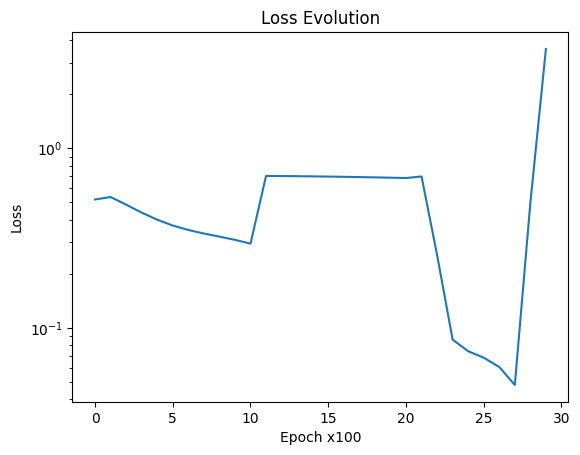

In [329]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [330]:
print(pde_loss(model, x, sigma1))
print(in_loss(model, func, T, sigma1, a))
print(out_loss(model, func, T, sigma1,  b))
print(time_loss(model, L, sigma1, v_max))

0.00062550575
0.082457386
0.2006896
13.583493


In [331]:
batch = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample

In [332]:
def theta_to_kappa(model, x, sigma1):
    theta, grad = jax.vmap(jax.value_and_grad(model))(x)

    return -2*sigma1 * (1/theta) * grad[:, 0]

def theta_to_rho(model, x, sigma1, v_max):
    kappa = theta_to_kappa(model, x, sigma1)
    return 0.5 * (1 - (kappa/v_max))

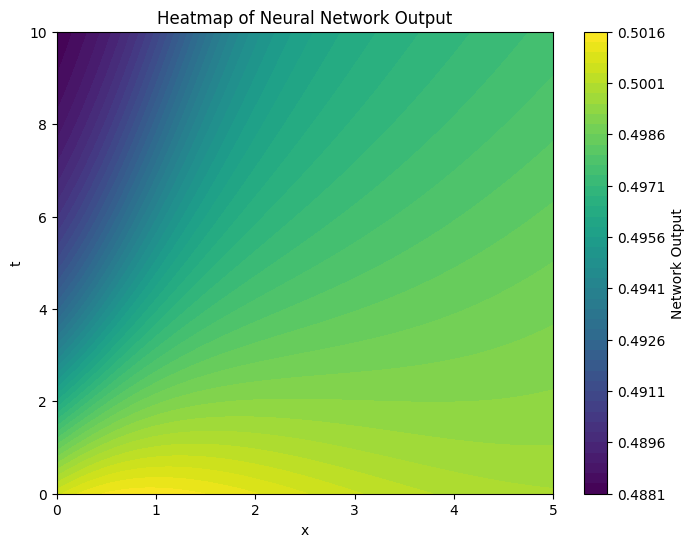

In [333]:
n_points = 200
x = jnp.linspace(0, L, n_points)
t = jnp.linspace(0, T, n_points)
X_grid, T_grid = jnp.meshgrid(x, t)
inputs = jnp.stack((X_grid.flatten(), T_grid.flatten()), axis=-1)

outputs = theta_to_rho(model, inputs, sigma1, v_max)
outputs = outputs.reshape(n_points, n_points)

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, T_grid, outputs, levels=50, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output')
plt.show()

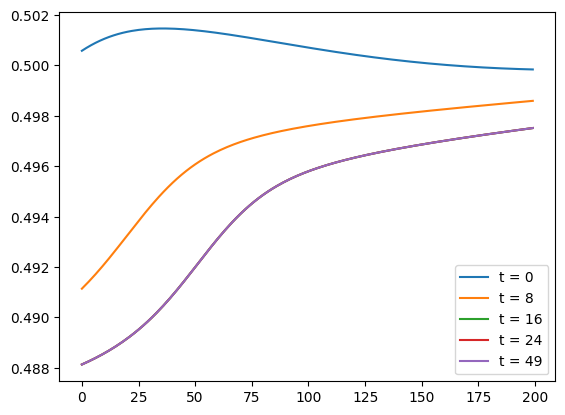

In [334]:

plt.plot(outputs[0], label='t = 0')
plt.plot(outputs[100], label='t = 8')
plt.plot(outputs[300], label='t = 16')
plt.plot(outputs[600], label='t = 24')
plt.plot(outputs[999], label='t = 49')
#plt.ylim([0.3, 0.7])
plt.legend()
plt.show()

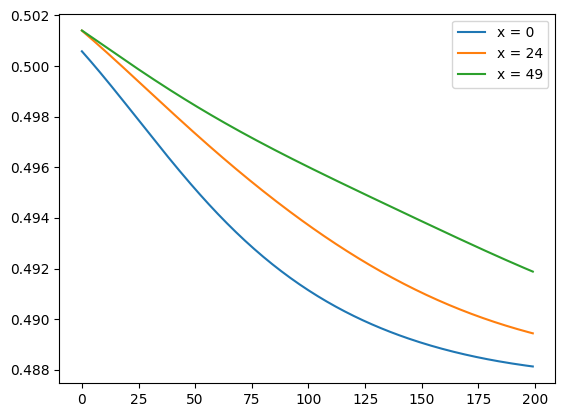

: 

In [335]:
plt.plot(outputs.T[0], label='x = 0')
plt.plot(outputs.T[24], label='x = 24')
plt.plot(outputs.T[49], label='x = 49')
plt.legend()
plt.show()

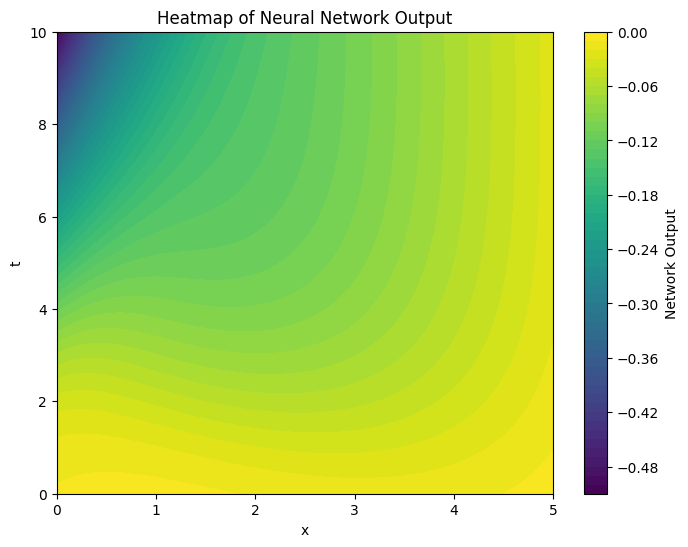

In [324]:
n_points = 200
x = jnp.linspace(0, L, n_points)
t = jnp.linspace(0, T, n_points)
X_grid, T_grid = jnp.meshgrid(x, t)
inputs = jnp.stack((X_grid.flatten(), T_grid.flatten()), axis=-1)

outputs = jax.vmap(model)(inputs)
outputs = outputs.reshape(n_points, n_points)

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, T_grid, outputs, levels=50, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output')
plt.show()